In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import keras
import time
import os

from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras_preprocessing import sequence
from keras.preprocessing import text
from keras import preprocessing
from keras import regularizers
from keras import activations
from keras import optimizers
from keras import callbacks
from keras import layers
from keras import losses
from keras import models

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Parameters

In [2]:
data_path = '../data/small_nn_data_1680888160.pickle'
dictionary_path = '../data/small_dictionary_1680888160.pickle'

maxlen=500
max_words=10000
first_split = 0.8
second_split=0.8

General functions

In [3]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [4]:
def print_confusion_matrix(model, x_test, y_test, labels, threshold=None):
    y_pred = model.predict(x_test, verbose=0, batch_size=batch_size)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_test, y_pred)
    if threshold is not None:
        cm[cm>threshold] = threshold
    output_size = len(labels)
    ticks=np.linspace(0, output_size-1, num=output_size)
    plt.clf()
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='none')
    plt.colorbar()
    plt.xticks(ticks, fontsize=10, labels=labels, rotation=90)
    plt.xlabel("Predicted")
    plt.yticks(ticks, fontsize=10, labels=labels)
    plt.ylabel("True")
    plt.grid(True)
    plt.show()

In [5]:
def print_evaluation(model, x_test, y_test, batch_size):
    loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    print(f"Test loss: {round(loss, 4)}")    
    print(f"Test acc: {round(acc*100, 2)}%")

In [6]:
def load_data(data_path, dictionary_path):
    with open(data_path, 'rb') as file:
        data = pickle.load(file)
    
    with open(dictionary_path, 'rb') as file:
        dictionary = pickle.load(file)
        dictionary = {value: key for key, value in dictionary.items()}
        
    labels_count = len(dictionary)
    texts = []
    labels = []
    for text, category in data:
        new_categories = np.zeros(labels_count, dtype='float32')
        new_categories[category] = 1.0
        texts.append(text)
        labels.append(new_categories)
        
        
    return texts, labels, dictionary

In [7]:
def prepare_data(texts, labels, maxlen=None, max_words=10000):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    
    sequences = tokenizer.texts_to_sequences(texts)
    if maxlen is not None:
        data = pad_sequences(sequences, maxlen=maxlen)
    else:
        data = pad_sequences(sequences)

    return data, np.asarray(labels), tokenizer

In [8]:
def split_data(data, labels, first_split=0.8, second_split=0.8):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=first_split)    
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size=second_split)
    return x_train, y_train, x_valid, y_valid, x_test, y_test

### Load and preprocess dataset

Load preprocessed yelp dataset and dictionary. The dictionary is then inverted

In [9]:
texts, labels, dictionary = load_data(data_path, dictionary_path)

Tokenize initially processed dataset

In [10]:
data, labels, tokenizer = prepare_data(texts, labels, maxlen=maxlen, max_words=max_words)
texts = None

Split the data to train, valid and test datasets

In [11]:
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(data, labels, first_split=first_split, second_split=second_split)
data = None
labels = None

Save tokenizer

In [12]:
tokenizer_time = int(time.time())
with open(f'../models/tokenizer_{tokenizer_time}.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
tokenizer = None

Print information about the datasets

In [13]:
print(f'Training samples:   {x_train.shape[0]}')
print(f'Testing samples:    {x_test.shape[0]}')
print(f'Validating samples: {x_valid.shape[0]}')

Training samples:   92097
Testing samples:    28781
Validating samples: 23025


### Create Neural Network Model v1

Model parameters

In [14]:
model_name = 'tc_model_1'
embedding_dim = 50
batch_size = 512
epochs = 30

Create model architecture

In [15]:
model = models.Sequential([
    # embedding layer
    layers.Embedding(max_words, embedding_dim, input_length=len(x_train[0])),
    
    # GRU layers
    layers.GRU(74, return_sequences=True, kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4), dropout=0.5),
    layers.LayerNormalization(),
    
    layers.GRU(37, kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4), dropout=0.5),
    layers.LayerNormalization(),
    
    # dense layer
    layers.Dense(len(dictionary), activation=layers.PReLU(), kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4)),
    layers.Dropout(0.5),
    
    # last layer
    layers.Dense(len(dictionary), activation='sigmoid', kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4))
])

# compile model
model.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=optimizers.Nadam(),
    metrics=['acc']
)

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           500000    
                                                                 
 gru (GRU)                   (None, 500, 74)           27972     
                                                                 
 layer_normalization (LayerN  (None, 500, 74)          148       
 ormalization)                                                   
                                                                 
 gru_1 (GRU)                 (None, 37)                12543     
                                                                 
 layer_normalization_1 (Laye  (None, 37)               74        
 rNormalization)                                                 
                                                                 
 dense (Dense)               (None, 37)                1

Train the network

In [16]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=epochs, 
    batch_size=batch_size,
    validation_data=(x_valid, y_valid)
)

Epoch 1/30
180/180 [==============================] - 44s 220ms/step - loss: 3.7215 - acc: 0.0362 - val_loss: 3.5905 - val_acc: 0.0509
Epoch 2/30
180/180 [==============================] - 40s 221ms/step - loss: 3.3676 - acc: 0.0851 - val_loss: 2.7238 - val_acc: 0.2366
Epoch 3/30
180/180 [==============================] - 39s 216ms/step - loss: 2.4491 - acc: 0.2901 - val_loss: 1.9018 - val_acc: 0.4955
Epoch 4/30
180/180 [==============================] - 38s 214ms/step - loss: 1.9782 - acc: 0.4356 - val_loss: 1.6622 - val_acc: 0.5554
Epoch 5/30
180/180 [==============================] - 39s 216ms/step - loss: 1.8034 - acc: 0.4948 - val_loss: 1.5610 - val_acc: 0.5868
Epoch 6/30
180/180 [==============================] - 39s 216ms/step - loss: 1.7055 - acc: 0.5273 - val_loss: 1.4942 - val_acc: 0.6051
Epoch 7/30
180/180 [==============================] - 38s 213ms/step - loss: 1.6285 - acc: 0.5511 - val_loss: 1.4497 - val_acc: 0.6190
Epoch 8/30
180/180 [==============================] - 3

Save the trained model

In [17]:
model.save(f'../models/{model_name}_{int(time.time())}_tt_{tokenizer_time}.h5')

### Visualize model v1 training results

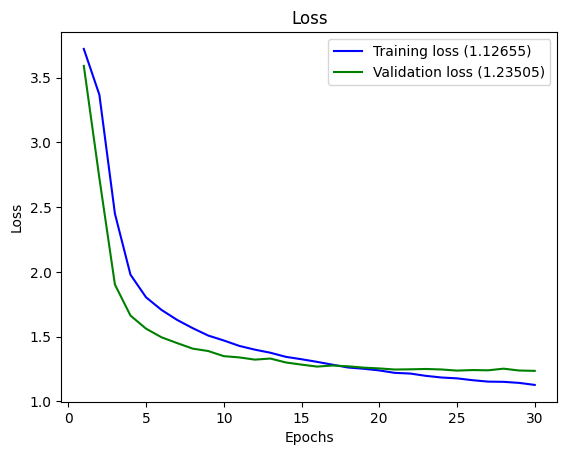

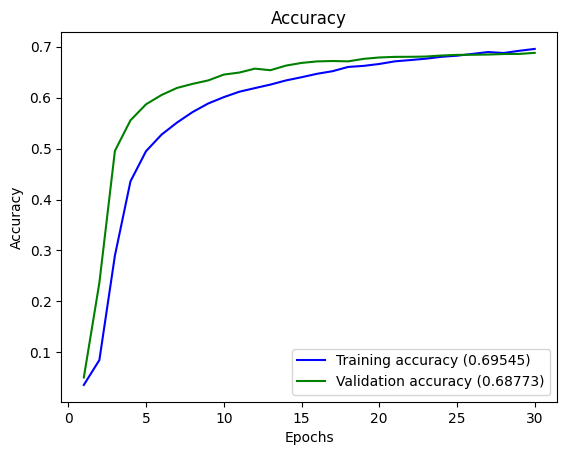

In [18]:
plot_history(history)

<Figure size 640x480 with 0 Axes>

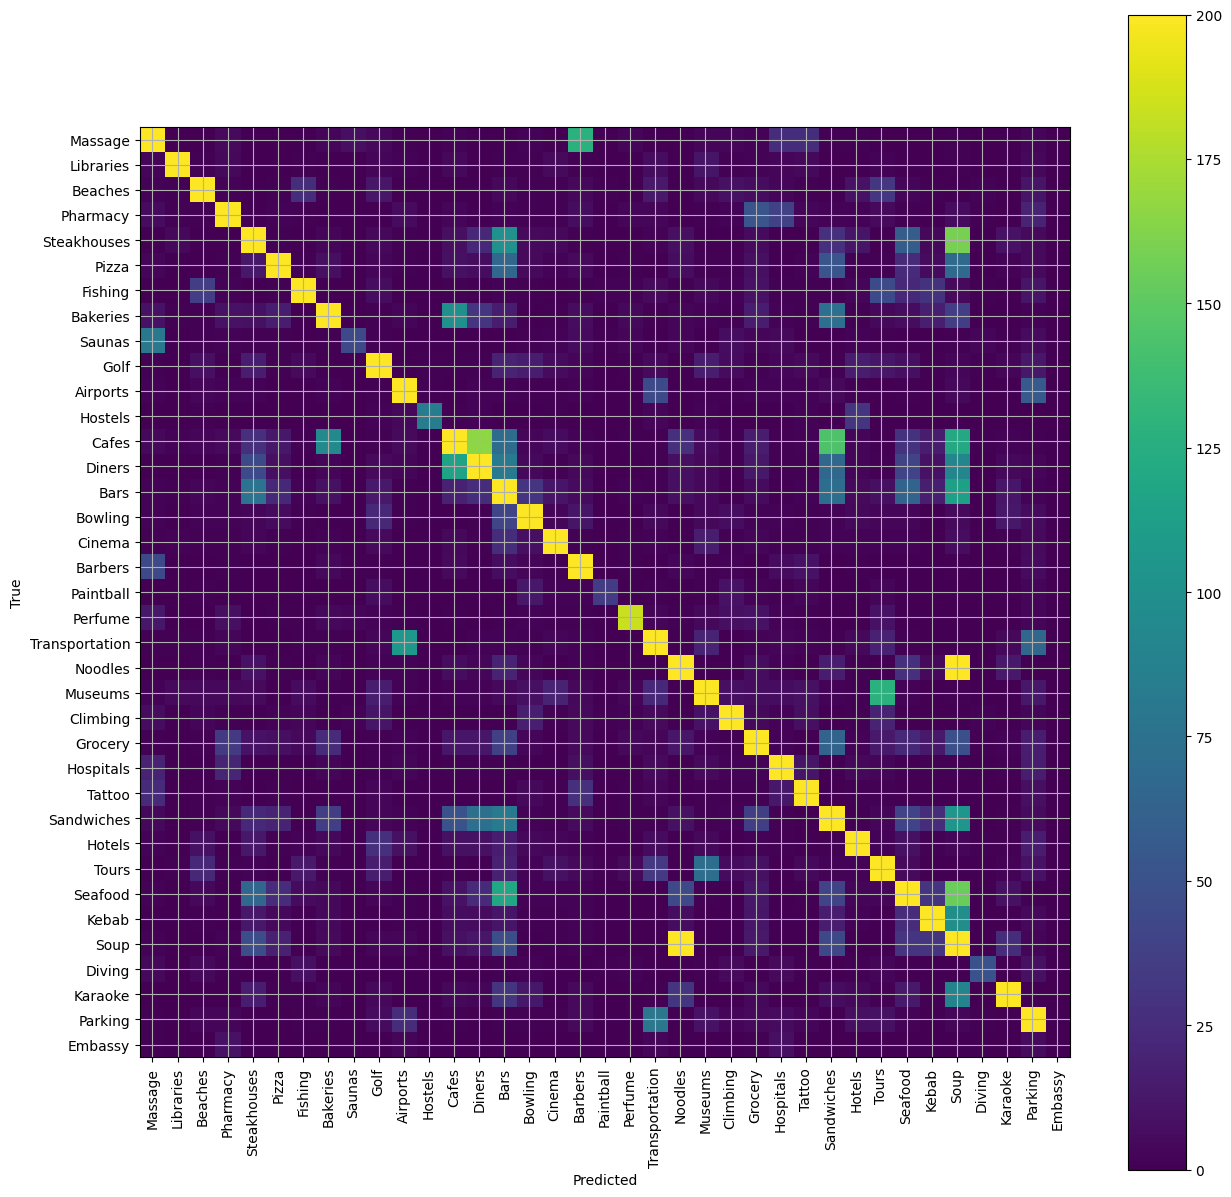

In [19]:
print_confusion_matrix(model, x_test, y_test, list(dictionary.values()), threshold=200)

In [20]:
print_evaluation(model, x_test, y_test, batch_size=batch_size)

Test loss: 1.237
Test acc: 68.46%


### Train Model v2

In [21]:
model_name = 'tc_model_2'
embedding_dim = 10
batch_size = 32
epochs = 30

In [22]:
model = models.Sequential([
    # embedding layer
    layers.Embedding(max_words, embedding_dim, input_length=len(x_train[0])),
    
    # conv & pooling layer
    layers.Conv1D(10, 3, activation=layers.PReLU(), kernel_regularizer=regularizers.L1L2(l1=5e-4, l2=5e-4), padding='same'),
    layers.AveragePooling1D(3),
    layers.LayerNormalization(),
    
    # GRU layers
    layers.GRU(10, return_sequences=True, kernel_regularizer=regularizers.L1L2(l1=5e-4, l2=5e-4), dropout=0.5),
    layers.LayerNormalization(),
    
    layers.GRU(10, kernel_regularizer=regularizers.L1L2(l1=5e-4, l2=5e-4), dropout=0.5),
    layers.LayerNormalization(),
    
    # dense & dropout layer
    layers.Dense(10, activation=layers.PReLU(), kernel_regularizer=regularizers.L1L2(l1=5e-4, l2=5e-4)),
    layers.LayerNormalization(),
    layers.Dropout(0.5),
    
    # last layer
    layers.Dense(len(dictionary), activation='sigmoid', kernel_regularizer=regularizers.L1L2(l1=5e-4, l2=5e-4))
])

# compile model
model.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=optimizers.Nadam(learning_rate=0.001, clipnorm=1.0, clipvalue=1.0),
    metrics=['acc']
)

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 10)           100000    
                                                                 
 conv1d (Conv1D)             (None, 500, 10)           5310      
                                                                 
 average_pooling1d (AverageP  (None, 166, 10)          0         
 ooling1D)                                                       
                                                                 
 layer_normalization_2 (Laye  (None, 166, 10)          20        
 rNormalization)                                                 
                                                                 
 gru_2 (GRU)                 (None, 166, 10)           660       
                                                                 
 layer_normalization_3 (Laye  (None, 166, 10)         

In [23]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=epochs,  
    batch_size=batch_size,
    validation_data=(x_valid, y_valid)
)

Epoch 1/30
2879/2879 [==============================] - 119s 39ms/step - loss: 3.4891 - acc: 0.0516 - val_loss: 2.9041 - val_acc: 0.1150
Epoch 2/30
2879/2879 [==============================] - 113s 39ms/step - loss: 2.8888 - acc: 0.1059 - val_loss: 2.6708 - val_acc: 0.1528
Epoch 3/30
2879/2879 [==============================] - 114s 39ms/step - loss: 2.7204 - acc: 0.1425 - val_loss: 2.4547 - val_acc: 0.2040
Epoch 4/30
2879/2879 [==============================] - 113s 39ms/step - loss: 2.5819 - acc: 0.1819 - val_loss: 2.2984 - val_acc: 0.2554
Epoch 5/30
2879/2879 [==============================] - 113s 39ms/step - loss: 2.4791 - acc: 0.2204 - val_loss: 2.1686 - val_acc: 0.3315
Epoch 6/30
2879/2879 [==============================] - 115s 40ms/step - loss: 2.3997 - acc: 0.2569 - val_loss: 2.0892 - val_acc: 0.3650
Epoch 7/30
2879/2879 [==============================] - 113s 39ms/step - loss: 2.3489 - acc: 0.2763 - val_loss: 2.0799 - val_acc: 0.3820
Epoch 8/30
2879/2879 [===================

In [24]:
model.save(f'../models/{model_name}_{int(time.time())}_tt_{tokenizer_time}.h5')

### Visualize model v2 training results

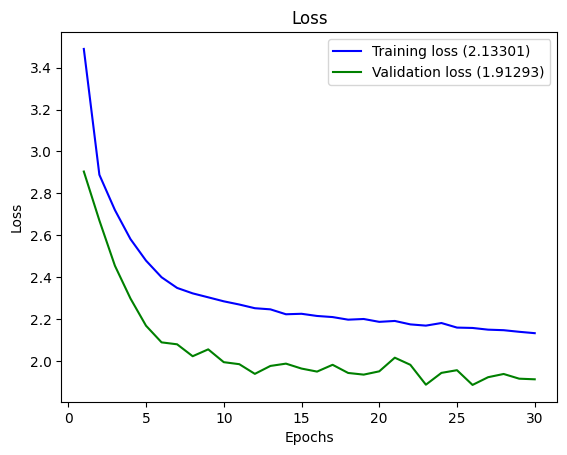

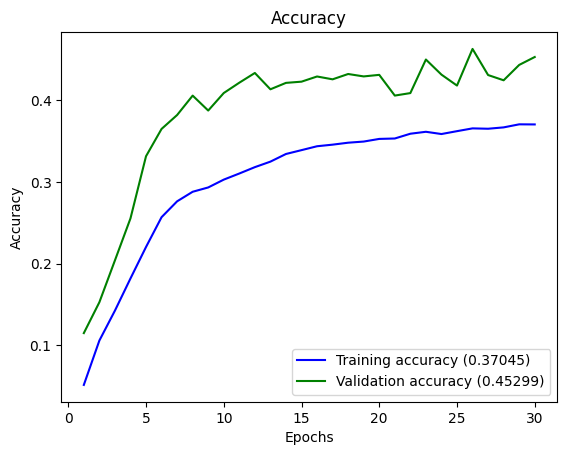

In [25]:
plot_history(history)

<Figure size 640x480 with 0 Axes>

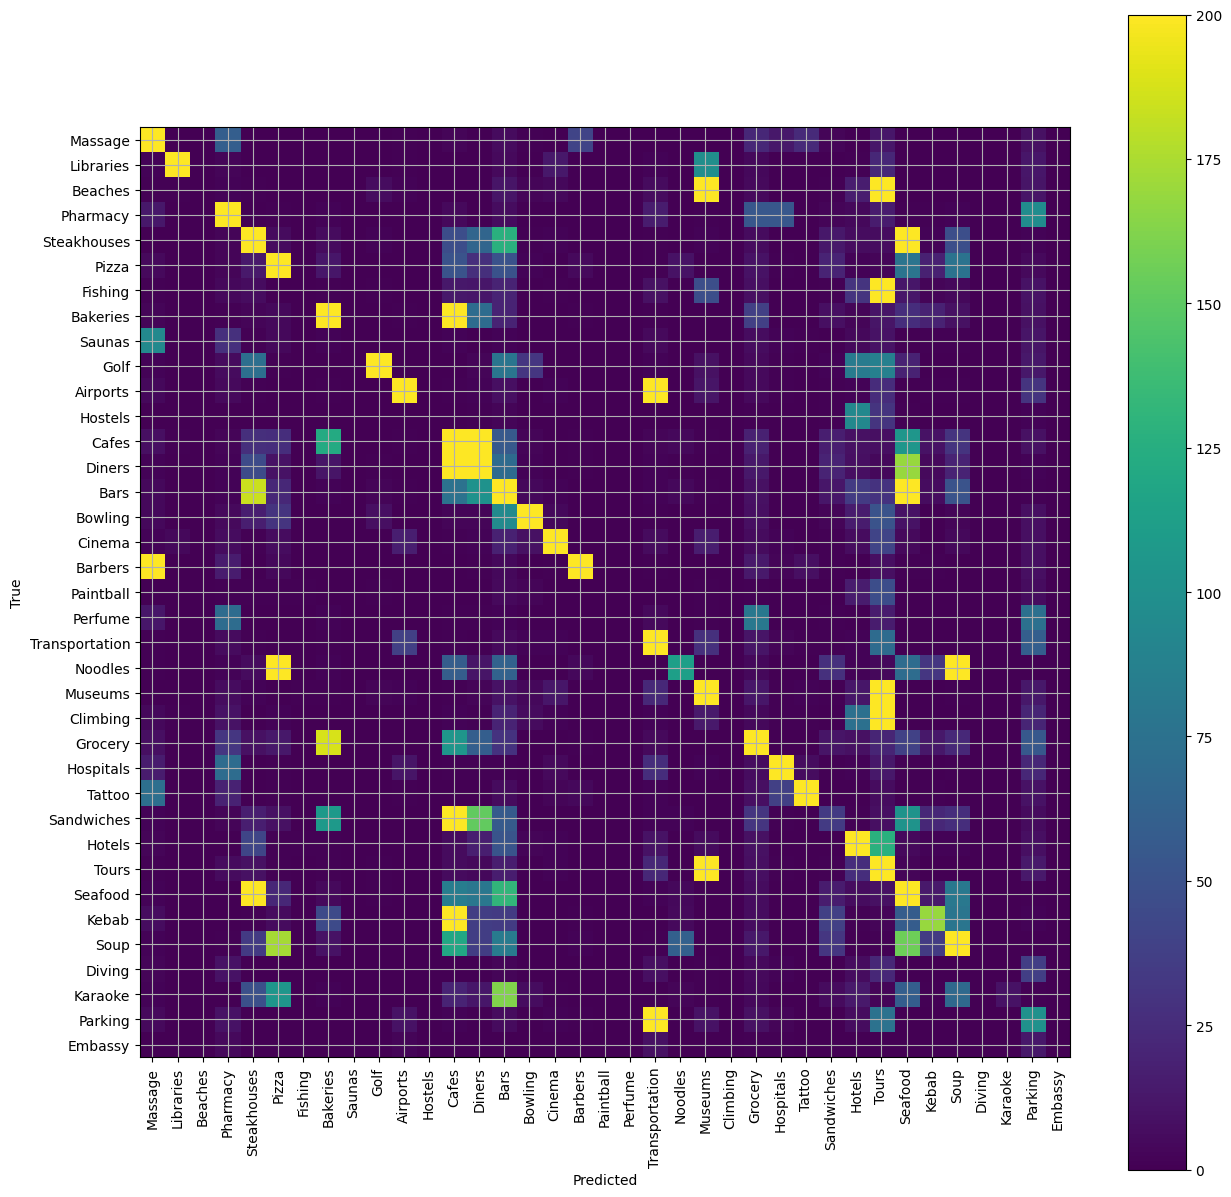

In [26]:
print_confusion_matrix(model, x_test, y_test, list(dictionary.values()), threshold=200)

In [27]:
print_evaluation(model, x_test, y_test, batch_size=batch_size)

Test loss: 1.9286
Test acc: 44.85%
